<table style="width: 100%;">
    <tr style="background-color: transparent;"><td>
        <img src="https://data-88e.github.io/assets/images/blue_text.png" width="250px" style="margin-left: 0;" />
    </td><td>
        <p style="text-align: right; font-size: 10pt;"><strong>Economic Models</strong>, Fall 2024<br>
            Dr. Eric Van Dusen</p></td></tr>
</table>

# Lab 9: Water Guard Randomized Controlled Trial

This lab is an adaptation from a set of notebooks developed for a full semester Data Science Connector Course taught in Fall 2017, entitled "Behind the Curtain in Economic Development".  This dataset come from a randomized controlled trial household survey carried out in Eastern Kenya in 2007-2008. 

The purpose of the study was to understand how to promote the use of WaterGuard, a dilute sodium hypochlorite solution that was promoted for Point-of-use household water disinfection.  There were seven arms in the study, which will be more fully described in the following chart:


<img src="Slide1.png"  />

Within this table you can see the seven treatments arms -  control plus three treatments -  in the bolded boxes in the middle with the number of springs and households. The study was carried out as a part of a study of households who gather drinking water from springs in a rural area.  The three boxes at the bottom describe the three rounds of data collection - a baseline before the treatment, and a short term and long term follow-up.  

<!-- **Notebook Outline**

1. [Mapping](#Mapping)
2. [Balance Check](#Balance)
3. [Baseline and a Randomly Selected Compound](#Baseline)
4. [Chlorine Usage outcome variables](#Chlorine)
5. [Graph of outcomes by Treatment Arm](#Graph)  -->

In [57]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pandas import read_stata
from ipyleaflet import Map, basemaps, Marker, AwesomeIcon

## Mapping

<div id="Mapping"></div>


This first section works with a package in Jupyter called ipyleaflet.

`ipyleaflet`;
the documentation is [here](https://ipyleaflet.readthedocs.io/en/latest/)
and it is worth a short read through if you are interested.


We want to use two different base maps - one is a satellite layer and oen is the Open Street Map layer.  

We will start by reading in a dataset of the coordinates of the springs that are used in the WaterGuard Promotion (WGP) study.  These springs were randomized into seven different treatment arms.  The springs are identified by a unique numerical id tag, and the common name in the local language.  


In [58]:
springsGPS = Table.read_table('WGPgps_forData8.csv')
springsGPS

a2_spring_id,a3_spring_name,treatment_arm,gpsn1,gpse1,gps1all
1010,JIKAZE SOWETO,6,0.39985,34.49,".39985,34.49003"
1013,ROHO SAFI,4,0.398933,34.4898,".3989333,34.48985"
1014,OTWOMA,6,0.339083,34.4355,".3390833,34.4355"
1015,MUKOYA,5,0.358317,34.4412,".3583167,34.44122"
1021,OKELLO,6,0.355983,34.4314,".3559833,34.43142"
5001,NAKHALIRO A,6,0.439167,34.3992,".4391667,34.39919"
5002,NAKHALIRO 'B',4,0.439033,34.4019,".4390333,34.40192"
5004,OSIMBO,1,0.411583,34.3644,".4115833,34.36442"
5007,TANDE,7,0.433667,34.4325,".4336667,34.43255"
5008,MUKABANA,6,0.408483,34.4591,".4084833,34.45912"


In [59]:
# make a table wth just the North and East Gps columns 
locations = springsGPS.select("gpsn1", "gpse1")
locations

gpsn1,gpse1
0.39985,34.49
0.398933,34.4898
0.339083,34.4355
0.358317,34.4412
0.355983,34.4314
0.439167,34.3992
0.439033,34.4019
0.411583,34.3644
0.433667,34.4325
0.408483,34.4591


Where in the world are we?

First of all, let's look at the mean for the latitude and longitude, and we can center our map there:

In [60]:
mean_longitude = springsGPS.column('gpse1').mean()
mean_latitude = springsGPS.column('gpsn1').mean()

print("Mean of 'gpse1':", mean_longitude)
print("Mean of 'gpsn1':", mean_latitude)

Mean of 'gpse1': 34.4179509091
Mean of 'gpsn1': 0.402962309091


The code cell below should display a map. However, it may not run the first time you click it - if this happens, try running all the cells above this one and then refreshing your browser. After a few refreshes, the maps should load.

`ipyleaflet` can take the following parameters: 
 - `center` - where to place the center of the map (you can still zoom in and out) 
 - `zoom` - zoom level to start at 
 - `basemap` - what tiles to draw the underlying, base map from 
 - `layout` - specifying the size that it will display 

In [61]:
center = [0.4, 34.4]
zoom = 12
basemap=basemaps.Esri.WorldImagery
basemap_osm=basemaps.OpenStreetMap.Mapnik
layout={'width': '800px', 'height': '600px'}

Map(basemap=basemap, center=center, zoom=zoom, layout=layout)

Map(center=[0.4, 34.4], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

Let's make a map of our sample sites (springs):

In [62]:
m = Map(basemap=basemap, center=center, zoom=zoom, layout=layout)

# Add the rows from the dataset
for row in springsGPS.rows:
    latitude = row.item('gpsn1')
    longitude = row.item('gpse1')
    marker = Marker(location=(latitude, longitude))
    m.add_layer(marker)

m

Map(center=[0.4, 34.4], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

The most interesting bit of data, the Treatment Arm, is still not being used. Let's assign different colors to the different treatment arms so that when we map it we can see if the arms appear to be randomly distributed.

The following is function assigns the 7 different treatment arms to a set of colors. [Here](https://www.w3.org/TR/css3-color/#html4) is the colors reference if you are interested!

In [63]:
def color(arm):
    if arm == 1:
        return 'black'
    elif arm == 2:
        return 'red'
    elif arm == 3:
        return 'purple'
    elif arm == 4:
        return 'green'
    elif arm == 5:
        return 'blue'
    elif arm == 6:
        return 'pink'
    elif arm == 7:
        return 'orange'

In [64]:
# Using the .apply method, you can apply any function to a data frame
colors = springsGPS.apply(color, "treatment_arm")
springsGPS = springsGPS.with_column("color", colors)
springsGPS

a2_spring_id,a3_spring_name,treatment_arm,gpsn1,gpse1,gps1all,color
1010,JIKAZE SOWETO,6,0.39985,34.49,".39985,34.49003",pink
1013,ROHO SAFI,4,0.398933,34.4898,".3989333,34.48985",green
1014,OTWOMA,6,0.339083,34.4355,".3390833,34.4355",pink
1015,MUKOYA,5,0.358317,34.4412,".3583167,34.44122",blue
1021,OKELLO,6,0.355983,34.4314,".3559833,34.43142",pink
5001,NAKHALIRO A,6,0.439167,34.3992,".4391667,34.39919",pink
5002,NAKHALIRO 'B',4,0.439033,34.4019,".4390333,34.40192",green
5004,OSIMBO,1,0.411583,34.3644,".4115833,34.36442",black
5007,TANDE,7,0.433667,34.4325,".4336667,34.43255",orange
5008,MUKABANA,6,0.408483,34.4591,".4084833,34.45912",pink


## Map with markers that have a different color for each treatment arm

In [65]:
m = Map(basemap=basemap, center=center, zoom=zoom, layout=layout)

for row in springsGPS.rows:
    latitude = row.item('gpsn1')
    longitude = row.item('gpse1')
    color = row.item('color')
    
    marker = Marker(
        location=(latitude, longitude),
        draggable=False,  # Set to True if you want to make the markers draggable
        title=color,      # Set the marker title to the color for tooltip
        alt=color         # Set the alt text to the color
    )
    marker.icon = AwesomeIcon(name='circle', marker_color=color)
    
    m.add_layer(marker)

m

Map(center=[0.4, 34.4], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

In [66]:
#change the Basemap layer to Open Street Map

m=Map(basemap=basemap_osm, center=center, zoom=zoom, layout=layout)

# Iterate through the rows in the dataset
for row in springsGPS.rows:
    latitude = row.item('gpsn1')
    longitude = row.item('gpse1')
    color = row.item('color')
    
    # Create a marker with the specified color
    marker = Marker(
        location=(latitude, longitude),
        draggable=False,  # Set to True if you want to make the markers draggable
        title=color,      # Set the marker title to the color for tooltip
        alt=color         # Set the alt text to the color
    )
    
    # Apply the specified color to the marker
    marker.icon = AwesomeIcon(name='circle', marker_color=color)
    
    m.add_layer(marker)

m

Map(center=[0.4, 34.4], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

Do the colors seem randomly distributed?

In fact, the randomization was performed on just a list of the springs using a random number generator. 
It did not take spatial distribution into effect.  


<!-- BEGIN QUESTION -->

**Question 1:** A Thought Experiment on Spatial Randomization
- What could you do to test whether the Treatment arms are spatially distributed?
- What could you do to randomize the treatment arms over space?

_I don't know any strong statistical methods to test for spatial randomization, but one idea I have is to divide the map into quadrants (or some other dividing factor), and count the different arms in each quadrant. If there is clearly more of one arm in a quadrant, then it is probably not spatially distributed.<br><br>
Perhaps you could first divide the map into roughly equal sections. Then, you assign a certain (equal) number of each arm to the individual sections. Now that you know each geographical area will have roughly the same number of each arm, you can randomize within the specified sections to assign each treatment to a house/well. While this probably isn't a perfect solution, it allows for spatial distribution while keeping the randomness factor of the RCT._

<!-- END QUESTION -->

<div id="Balance"></div>

## Balance Check and Variable Names

### Baseline Survey 
This is our first look at the survey dataset.  These are a limited set of questions/answers from a simple and short baseline survey. However it is a lot bigger and messier than the datasets we have seen so far and in Data 8. 

Data variable names follow along with the survey below, referred to by the section, a,b,c... number, 1,2,3... and a few words about the question. 

The purpose of this section will be: 
* to get a familiarity with the dataset, 
* to look at some background descriptor variables of the households, 
* to start to think about missing values and coding of subsets of the data.  
* to check the randomization of households by seeeing if the different arms of the study are balanced across some of the key baseline variables.  

**The surveys that illustrate the raw data names are in a file linked [here](https://drive.google.com/open?id=1UVoiVn7LJ4rn7WEb-9BJ96jmdJ2FBk60). You have to go and look through this survey to understand the variables.**

**The code sheet that has the codes for some of the possible answers are in a file linked [here](https://drive.google.com/file/d/1iinJXExeVKV4Dm7tRKOiotoYUDSXMyqc). You have to go and look through this code sheet in a later section.**

In [67]:
WGP_baseline = Table.read_table("WGP_baseline_Data8.csv")
WGP_baseline

a1_cmpd_id,a2_spring_id,a3_spring_name,a5_date_interview_day,a5_date_interview_month,a5_date_interview_year,a6_interviewer_id,a6_interviewer_name,b1_gender,b2_relation_youngest_child,b3_birth_year,b4_spouse_birth_year,b5_tribe,b7_tribe_spouse,b9_education,b10_spouse_education,b11_womens_group_member,b12_credit_group_member,b13_prayer_group_member,b14_burial_cmte_member,b15_other_group_member,b16_occupation1,b17_spouse_occupation1,b18_religion,b19_use_spring,c1a_wg_heard_ever,c2a_wg_used_ever,c3a_wg_water_currently_treat,c4a_wg_used_past_month,c5a_wg_received_past_month,d1_material_floors,d2_electricity,d3_latrine,d4_rent_or_own,d5_rent_amt,d10a_bicycle,d10b_kerosene_stove,d10c_radio_cassette,d10d_bed,d10e_hoe,d10f_sofa_pieces,d10g_cattle,d10h_goat,d11_iron_roof,h1_script_read,wave,round,wave_round,sid,assignment,treatment_arm,e1_num_kids_under_5,e2b_01_gender,e2b_02_gender,e2b_03_gender,e2b_04_gender,e2b_05_gender,e2b_06_gender,e2b_07_gender,e2b_08_gender,e2b_09_gender,e2b_10_gender,e2b_11_gender,e2b_12_gender,e2b_13_gender,e2b_14_gender,e2b_15_gender,e2b_16_gender,e2c_01_birth_date_months,e2c_01_birth_date_years,e2c_02_birth_date_months,e2c_02_birth_date_years,e2c_03_birth_date_months,e2c_03_birth_date_years,e2c_04_birth_date_months,e2c_04_birth_date_years,e2c_05_birth_date_months,e2c_05_birth_date_years,e2c_06_birth_date_months,e2c_06_birth_date_years,e2c_07_birth_date_months,e2c_07_birth_date_years,e2c_08_birth_date_months,e2c_08_birth_date_years,e2c_09_birth_date_months,e2c_09_birth_date_years,e2c_10_birth_date_months,e2c_10_birth_date_years,e2c_11_birth_date_months,e2c_11_birth_date_years,e2c_12_birth_date_months,e2c_12_birth_date_years,e2c_13_birth_date_months,e2c_13_birth_date_years,e2c_14_birth_date_months,e2c_14_birth_date_years,e2c_15_birth_date_months,e2c_15_birth_date_years,e2c_16_birth_date_months,e2c_16_birth_date_years,e2d_01_age_months,e2d_01_age_weeks,e2d_01_age_years,e2d_02_age_months,e2d_02_age_weeks,e2d_02_age_years,e2d_03_age_months,e2d_03_age_weeks,e2d_03_age_years,e2d_04_age_months,e2d_04_age_weeks,e2d_04_age_years,e2d_05_age_months,e2d_05_age_weeks,e2d_05_age_years,e2d_06_age_months,e2d_06_age_weeks,e2d_06_age_years,e2d_07_age_months,e2d_07_age_weeks,e2d_07_age_years,e2d_08_age_months,e2d_08_age_weeks,e2d_08_age_years,e2d_09_age_months,e2d_09_age_weeks,e2d_09_age_years,e2d_10_age_months,e2d_10_age_weeks,e2d_10_age_years,e2d_11_age_months,e2d_11_age_weeks,e2d_11_age_years,e2d_12_age_months,e2d_12_age_weeks,e2d_12_age_years,e2d_13_age_months,e2d_13_age_weeks,e2d_13_age_years,e2d_14_age_months,e2d_14_age_weeks,e2d_14_age_years,e2d_15_age_months,e2d_15_age_weeks,e2d_15_age_years,e2d_16_age_months,e2d_16_age_weeks,e2d_16_age_years,e2e_01_a_fever_malaria,e2e_01_b_vomiting,e2e_01_c_cough,e2e_01_d_diarrhea,e2e_02_a_fever_malaria,e2e_02_b_vomiting,e2e_02_c_cough,e2e_02_d_diarrhea,e2e_03_a_fever_malaria,e2e_03_b_vomiting,e2e_03_c_cough,e2e_03_d_diarrhea,e2e_04_a_fever_malaria,e2e_04_b_vomiting,e2e_04_c_cough,e2e_04_d_diarrhea,e2e_05_a_fever_malaria,e2e_05_b_vomiting,e2e_05_c_cough,e2e_05_d_diarrhea,e2e_06_a_fever_malaria,e2e_06_b_vomiting,e2e_06_c_cough,e2e_06_d_diarrhea,e2e_07_a_fever_malaria,e2e_07_b_vomiting,e2e_07_c_cough,e2e_07_d_diarrhea,e2e_08_a_fever_malaria,e2e_08_b_vomiting,e2e_08_c_cough,e2e_08_d_diarrhea,e2e_09_a_fever_malaria,e2e_09_b_vomiting,e2e_09_c_cough,e2e_09_d_diarrhea,e2e_10_a_fever_malaria,e2e_10_b_vomiting,e2e_10_c_cough,e2e_10_d_diarrhea,e2e_11_a_fever_malaria,e2e_11_b_vomiting,e2e_11_c_cough,e2e_11_d_diarrhea,e2e_12_a_fever_malaria,e2e_12_b_vomiting,e2e_12_c_cough,e2e_12_d_diarrhea,e2e_13_a_fever_malaria,e2e_13_b_vomiting,e2e_13_c_cough,e2e_13_d_diarrhea,e2e_14_a_fever_malaria,e2e_14_b_vomiting,e2e_14_c_cough,e2e_14_d_diarrhea,e2e_15_a_fever_malaria,e2e_15_b_vomiting,e2e_15_c_cough,e2e_15_d_diarrhea,e2e_16_a_fever_malaria,e2e_16_b_vomiting,e2e_16_c_cough,e2e_16_d_diarrhea
500408,5004,OSIMBO,30,10,2007,338,IBRAHIM,2,1,1988,1982,2,4,8,12,1,1,1,1,2,6,1,22,1,1,1,2,2,2,2,2,1,1,nan,0,1,1,1,2,0,

### Misssing values 

If you look through the dataset above, and scroll to the right a ways to some of the last variables, you will notice that that there are a lot of cells with NaN, which means a missing value. For these cells no data was entered at the time of data entry. In some cases it may be appropriate to enter a zero and carry on with the analyis.  



In [68]:
WGP_base_dfna = WGP_baseline.to_df().fillna(0)
WGP_table = Table.from_df(WGP_base_dfna)
WGP_table

a1_cmpd_id,a2_spring_id,a3_spring_name,a5_date_interview_day,a5_date_interview_month,a5_date_interview_year,a6_interviewer_id,a6_interviewer_name,b1_gender,b2_relation_youngest_child,b3_birth_year,b4_spouse_birth_year,b5_tribe,b7_tribe_spouse,b9_education,b10_spouse_education,b11_womens_group_member,b12_credit_group_member,b13_prayer_group_member,b14_burial_cmte_member,b15_other_group_member,b16_occupation1,b17_spouse_occupation1,b18_religion,b19_use_spring,c1a_wg_heard_ever,c2a_wg_used_ever,c3a_wg_water_currently_treat,c4a_wg_used_past_month,c5a_wg_received_past_month,d1_material_floors,d2_electricity,d3_latrine,d4_rent_or_own,d5_rent_amt,d10a_bicycle,d10b_kerosene_stove,d10c_radio_cassette,d10d_bed,d10e_hoe,d10f_sofa_pieces,d10g_cattle,d10h_goat,d11_iron_roof,h1_script_read,wave,round,wave_round,sid,assignment,treatment_arm,e1_num_kids_under_5,e2b_01_gender,e2b_02_gender,e2b_03_gender,e2b_04_gender,e2b_05_gender,e2b_06_gender,e2b_07_gender,e2b_08_gender,e2b_09_gender,e2b_10_gender,e2b_11_gender,e2b_12_gender,e2b_13_gender,e2b_14_gender,e2b_15_gender,e2b_16_gender,e2c_01_birth_date_months,e2c_01_birth_date_years,e2c_02_birth_date_months,e2c_02_birth_date_years,e2c_03_birth_date_months,e2c_03_birth_date_years,e2c_04_birth_date_months,e2c_04_birth_date_years,e2c_05_birth_date_months,e2c_05_birth_date_years,e2c_06_birth_date_months,e2c_06_birth_date_years,e2c_07_birth_date_months,e2c_07_birth_date_years,e2c_08_birth_date_months,e2c_08_birth_date_years,e2c_09_birth_date_months,e2c_09_birth_date_years,e2c_10_birth_date_months,e2c_10_birth_date_years,e2c_11_birth_date_months,e2c_11_birth_date_years,e2c_12_birth_date_months,e2c_12_birth_date_years,e2c_13_birth_date_months,e2c_13_birth_date_years,e2c_14_birth_date_months,e2c_14_birth_date_years,e2c_15_birth_date_months,e2c_15_birth_date_years,e2c_16_birth_date_months,e2c_16_birth_date_years,e2d_01_age_months,e2d_01_age_weeks,e2d_01_age_years,e2d_02_age_months,e2d_02_age_weeks,e2d_02_age_years,e2d_03_age_months,e2d_03_age_weeks,e2d_03_age_years,e2d_04_age_months,e2d_04_age_weeks,e2d_04_age_years,e2d_05_age_months,e2d_05_age_weeks,e2d_05_age_years,e2d_06_age_months,e2d_06_age_weeks,e2d_06_age_years,e2d_07_age_months,e2d_07_age_weeks,e2d_07_age_years,e2d_08_age_months,e2d_08_age_weeks,e2d_08_age_years,e2d_09_age_months,e2d_09_age_weeks,e2d_09_age_years,e2d_10_age_months,e2d_10_age_weeks,e2d_10_age_years,e2d_11_age_months,e2d_11_age_weeks,e2d_11_age_years,e2d_12_age_months,e2d_12_age_weeks,e2d_12_age_years,e2d_13_age_months,e2d_13_age_weeks,e2d_13_age_years,e2d_14_age_months,e2d_14_age_weeks,e2d_14_age_years,e2d_15_age_months,e2d_15_age_weeks,e2d_15_age_years,e2d_16_age_months,e2d_16_age_weeks,e2d_16_age_years,e2e_01_a_fever_malaria,e2e_01_b_vomiting,e2e_01_c_cough,e2e_01_d_diarrhea,e2e_02_a_fever_malaria,e2e_02_b_vomiting,e2e_02_c_cough,e2e_02_d_diarrhea,e2e_03_a_fever_malaria,e2e_03_b_vomiting,e2e_03_c_cough,e2e_03_d_diarrhea,e2e_04_a_fever_malaria,e2e_04_b_vomiting,e2e_04_c_cough,e2e_04_d_diarrhea,e2e_05_a_fever_malaria,e2e_05_b_vomiting,e2e_05_c_cough,e2e_05_d_diarrhea,e2e_06_a_fever_malaria,e2e_06_b_vomiting,e2e_06_c_cough,e2e_06_d_diarrhea,e2e_07_a_fever_malaria,e2e_07_b_vomiting,e2e_07_c_cough,e2e_07_d_diarrhea,e2e_08_a_fever_malaria,e2e_08_b_vomiting,e2e_08_c_cough,e2e_08_d_diarrhea,e2e_09_a_fever_malaria,e2e_09_b_vomiting,e2e_09_c_cough,e2e_09_d_diarrhea,e2e_10_a_fever_malaria,e2e_10_b_vomiting,e2e_10_c_cough,e2e_10_d_diarrhea,e2e_11_a_fever_malaria,e2e_11_b_vomiting,e2e_11_c_cough,e2e_11_d_diarrhea,e2e_12_a_fever_malaria,e2e_12_b_vomiting,e2e_12_c_cough,e2e_12_d_diarrhea,e2e_13_a_fever_malaria,e2e_13_b_vomiting,e2e_13_c_cough,e2e_13_d_diarrhea,e2e_14_a_fever_malaria,e2e_14_b_vomiting,e2e_14_c_cough,e2e_14_d_diarrhea,e2e_15_a_fever_malaria,e2e_15_b_vomiting,e2e_15_c_cough,e2e_15_d_diarrhea,e2e_16_a_fever_malaria,e2e_16_b_vomiting,e2e_16_c_cough,e2e_16_d_diarrhea
500408,5004,OSIMBO,30,10,2007,338,IBRAHIM,2,1,1988,1982,2,4,8,12,1,1,1,1,2,6,1,22,1,1,1,2,2,2,2,2,1,1,0,0,1,1,1,2,0,0,

 Look at the variable names, and then look at the survey form to find the concordance of codes

In [69]:
# Here is a list of all of the possible categories / columns
list(WGP_table)

['a1_cmpd_id',
 'a2_spring_id',
 'a3_spring_name',
 'a5_date_interview_day',
 'a5_date_interview_month',
 'a5_date_interview_year',
 'a6_interviewer_id',
 'a6_interviewer_name',
 'b1_gender',
 'b2_relation_youngest_child',
 'b3_birth_year',
 'b4_spouse_birth_year',
 'b5_tribe',
 'b7_tribe_spouse',
 'b9_education',
 'b10_spouse_education',
 'b11_womens_group_member',
 'b12_credit_group_member',
 'b13_prayer_group_member',
 'b14_burial_cmte_member',
 'b15_other_group_member',
 'b16_occupation1',
 'b17_spouse_occupation1',
 'b18_religion',
 'b19_use_spring',
 'c1a_wg_heard_ever',
 'c2a_wg_used_ever',
 'c3a_wg_water_currently_treat',
 'c4a_wg_used_past_month',
 'c5a_wg_received_past_month',
 'd1_material_floors',
 'd2_electricity',
 'd3_latrine',
 'd4_rent_or_own',
 'd5_rent_amt',
 'd10a_bicycle',
 'd10b_kerosene_stove',
 'd10c_radio_cassette',
 'd10d_bed',
 'd10e_hoe',
 'd10f_sofa_pieces',
 'd10g_cattle',
 'd10h_goat',
 'd11_iron_roof',
 'h1_script_read',
 'wave',
 'round',
 'wave_round',

### What are some Variables that we want to specifically look at? ###

There are a lot of variables here and it can be kind of overwhelming, but it is good to see how many columns there can be in a comprehensive survey dataset.  

#### Front Page information - A variables

- household id
- spring id
- interviewer id

#### Information about respondent - B variables 

- tribe
- education
- age
- gender 
- group membership

#### Water Guard Use - C variables

For Waterguard (WG) usage

- `c1a` - Whether the respondent has ever heard of WG
- `c2a` - Whether the respondent has ever used WG
- `c3a` - Whether the respondent's water is currently treated with WG
- `c4a` - Whether the respondent has used WG in the past month

#### Durable / Capital Goods - D variables

- Whether the respondent has electricity / latrine / iron roof
- Number of of bicycle / radio / hoe / beds owned
- Number of animals owned

#### Child Health - E variables

- `e1_num_kids_under_5`: Number of kids under 5
- `e2_`:  This table becomes tricky because it has a different format. Each kid in the table is numbered 01, 02 and so on, and then the subsequent questions are keyed to that child number. e.g. `e2e_01_d_diarrhea`, `e2e_02_d_diarrhea` represent whether child 1 and 2 respectively have diarrhea. In total, four diseases are recorded:
    - Cough
    - Diarrhea
    - Malaria
    - Vomiting



 

### The Treatment Arm 

In the study, arm 1 is control, while Arms 2-7 are different types of treatment interventions:
 
- Arm 1 - Control
- Arm 2 - Household Script
- Arm 3 - Community Script
- Arm 4 - HH + Community Script
- Arm 5 - Flat-Fee Promoter + Coupons
- Arm 6 - Incentivized Promoter + Coupons
- Arm 7 - Incentivized Promoter + Dispenser at Spring

Let's check how many households are in each treatment arm.


In [70]:
WGP_table.group("treatment_arm")

treatment_arm,count
1,137
2,118
3,115
4,120
5,341
6,337
7,335


### Baseline Check - Exposure to Water Guard Use 

Let's see how many households have ever used Water Guards.

The data is currently Coded as 1 = Yes and 2 = No, so we can't really make sense of the Mean of the variable in its current form. Instead, we will make a new column/variable with the 1 or 2 answers translated into Yes or No.
Notably, we must first filter out respondents that had missing values (with value 0) for this question.



In [71]:
WGP_ever = WGP_table.where('c2a_wg_used_ever', are.above(0))
WGP_ever.group("c2a_wg_used_ever")

c2a_wg_used_ever,count
1,519
2,817


In [72]:
#This helper function goes through a column of choice, and spits out yes or no based off each value in the column. It returns an array of these yes and no's
def translate_to_yesno(table, col):
    dummy=[]
    table=table.where(col, are.above(0))
    for i in np.arange(table.num_rows):
        if table.column(col).item(i) == 1:
            dummy.append('Yes')
        else: #if not 1 then its 2 and 2 means no
            dummy.append("No")
    return dummy

In [73]:
new = translate_to_yesno(WGP_ever, 'c2a_wg_used_ever')
WGP_ever = WGP_ever.with_column('c2a_wg_used_ever',new)
WGP_ever.group('c2a_wg_used_ever')

c2a_wg_used_ever,count
No,817
Yes,519


### Pivoting and Balance Checks

Now we will use a command called **Pivot** to create a new table that has the percent of households who have ever used Water Guard within each Treatment Arm. 

We can first use it to do a  **balance check** for Water Guard use across Arms.

In [74]:
ever_yesno = WGP_ever.pivot('c2a_wg_used_ever','treatment_arm')
ever_yesno

treatment_arm,No,Yes
1,82,40
2,62,41
3,61,44
4,62,44
5,174,130
6,192,105
7,184,115


Converting to percentages...

In [75]:
total = ever_yesno.column(1) + ever_yesno.column(2)
ever_yesno = ever_yesno.with_columns('Percent No',ever_yesno.column(1) / total * 100, 
                                     'Percent Yes', ever_yesno.column(2) / total * 100)
ever_yesno

treatment_arm,No,Yes,Percent No,Percent Yes
1,82,40,67.2131,32.7869
2,62,41,60.1942,39.8058
3,61,44,58.0952,41.9048
4,62,44,58.4906,41.5094
5,174,130,57.2368,42.7632
6,192,105,64.6465,35.3535
7,184,115,61.5385,38.4615


Let's also repeat the process for the variable of whether the households are currently using Water Guard, `c3a_wg_water_currently_treat`.

In [76]:
WGP_current = WGP_table.where('c3a_wg_water_currently_treat',are.not_equal_to(0))
new2 = translate_to_yesno(WGP_current,'c3a_wg_water_currently_treat')
WGP_current = WGP_current.with_column('c3a_wg_water_currently_treat',new2)
WGP_current.group("c3a_wg_water_currently_treat")

c3a_wg_water_currently_treat,count
No,123
Yes,31


Do you notice a problem here? Look at the total numbers reported in the output above.

We can do the same percentage tables for the balance check but maybe there's a problem. 
Look at the total number of households answering the question and compare that to the total number from the previous section.

In [77]:
current_yesno = WGP_current.pivot('c3a_wg_water_currently_treat','treatment_arm')
total = current_yesno.column(1) + current_yesno.column(2)
current_yesno = current_yesno.with_columns('Percent No',current_yesno.column(1)/total * 100, 
                                           'Percent Yes', current_yesno.column(2)/total * 100)
current_yesno

treatment_arm,No,Yes,Percent No,Percent Yes
1,7,2,77.7778,22.2222
2,10,1,90.9091,9.09091
3,12,2,85.7143,14.2857
4,12,2,85.7143,14.2857
5,35,12,74.4681,25.5319
6,20,7,74.0741,25.9259
7,27,5,84.375,15.625


This seems like a really high usage, but **maybe this is due to missing values**. 

Let's now also include the 0 (missing) values in our analysis.


In [78]:
current_yesnomissing = WGP_table.pivot('c3a_wg_water_currently_treat','treatment_arm')
total = current_yesnomissing.column(1) + current_yesnomissing.column(2) + current_yesnomissing.column(3)
current_yesnomissing = current_yesnomissing.with_columns(
                                     'Percent Missing',current_yesnomissing.column("0.0") / total * 100, 
                                     'Percent No',current_yesnomissing.column("2.0") / total * 100, 
                                     'Percent Yes', current_yesnomissing.column("1.0") / total * 100)
current_yesnomissing

treatment_arm,0.0,1.0,2.0,Percent Missing,Percent No,Percent Yes
1,128,2,7,93.4307,5.10949,1.45985
2,107,1,10,90.678,8.47458,0.847458
3,101,2,12,87.8261,10.4348,1.73913
4,106,2,12,88.3333,10,1.66667
5,294,12,35,86.217,10.2639,3.51906
6,310,7,20,91.9881,5.93472,2.07715
7,303,5,27,90.4478,8.0597,1.49254


<!-- BEGIN QUESTION -->

**Question 2**

- Explain the previous table clearly and concisely, as if you were explaining it to someone who didn't know the back story.
- What does each rows/column mean?
- Conduct a balance check: does the distribution of yes/no/missing look balanced across arms?


_In the above table there are seven columns: The column treatment_arm indicates the sepcific treatment this group is receiving. The columns 0.0, 1.0, and 2.0 represent the number of people that had no response, responded yes, or responded no, respectively, when asked whether their water is currently treated with waterguard. A sum of those three columns is taken, and three columns (Percent Missing, Percent No, and Percent Yes) represent each of the responses as a percentage of the total number of people asked. As you go down the columns, you see the statistics for each of the seven treatment arms, or the seven different ways this RCT is being conducted._

<!-- END QUESTION -->

<div id="Baseline"></div>

## Baseline and a Randomly Selected Compound




Let's describe a household selected at random.

First, we will extract the household/compound id into an array.

In [79]:
hhld_array = WGP_table.column('a1_cmpd_id')
hhld_array

array([ 500408.,  501206.,  504637., ...,  514411.,  509118.,  511802.])

Next, we will draw randomly from this array.

In [80]:
random_generator = np.random.default_rng(seed=10) # Please keep this line so the code is deterministic.
randomhh = random_generator.choice(hhld_array)
print("My randomly selected household is household number", randomhh)

My randomly selected household is household number 502004.0


Then, let's look at the data for our randomly selected household:

In [81]:
myfamily = WGP_table.where("a1_cmpd_id",randomhh)
myfamily

a1_cmpd_id,a2_spring_id,a3_spring_name,a5_date_interview_day,a5_date_interview_month,a5_date_interview_year,a6_interviewer_id,a6_interviewer_name,b1_gender,b2_relation_youngest_child,b3_birth_year,b4_spouse_birth_year,b5_tribe,b7_tribe_spouse,b9_education,b10_spouse_education,b11_womens_group_member,b12_credit_group_member,b13_prayer_group_member,b14_burial_cmte_member,b15_other_group_member,b16_occupation1,b17_spouse_occupation1,b18_religion,b19_use_spring,c1a_wg_heard_ever,c2a_wg_used_ever,c3a_wg_water_currently_treat,c4a_wg_used_past_month,c5a_wg_received_past_month,d1_material_floors,d2_electricity,d3_latrine,d4_rent_or_own,d5_rent_amt,d10a_bicycle,d10b_kerosene_stove,d10c_radio_cassette,d10d_bed,d10e_hoe,d10f_sofa_pieces,d10g_cattle,d10h_goat,d11_iron_roof,h1_script_read,wave,round,wave_round,sid,assignment,treatment_arm,e1_num_kids_under_5,e2b_01_gender,e2b_02_gender,e2b_03_gender,e2b_04_gender,e2b_05_gender,e2b_06_gender,e2b_07_gender,e2b_08_gender,e2b_09_gender,e2b_10_gender,e2b_11_gender,e2b_12_gender,e2b_13_gender,e2b_14_gender,e2b_15_gender,e2b_16_gender,e2c_01_birth_date_months,e2c_01_birth_date_years,e2c_02_birth_date_months,e2c_02_birth_date_years,e2c_03_birth_date_months,e2c_03_birth_date_years,e2c_04_birth_date_months,e2c_04_birth_date_years,e2c_05_birth_date_months,e2c_05_birth_date_years,e2c_06_birth_date_months,e2c_06_birth_date_years,e2c_07_birth_date_months,e2c_07_birth_date_years,e2c_08_birth_date_months,e2c_08_birth_date_years,e2c_09_birth_date_months,e2c_09_birth_date_years,e2c_10_birth_date_months,e2c_10_birth_date_years,e2c_11_birth_date_months,e2c_11_birth_date_years,e2c_12_birth_date_months,e2c_12_birth_date_years,e2c_13_birth_date_months,e2c_13_birth_date_years,e2c_14_birth_date_months,e2c_14_birth_date_years,e2c_15_birth_date_months,e2c_15_birth_date_years,e2c_16_birth_date_months,e2c_16_birth_date_years,e2d_01_age_months,e2d_01_age_weeks,e2d_01_age_years,e2d_02_age_months,e2d_02_age_weeks,e2d_02_age_years,e2d_03_age_months,e2d_03_age_weeks,e2d_03_age_years,e2d_04_age_months,e2d_04_age_weeks,e2d_04_age_years,e2d_05_age_months,e2d_05_age_weeks,e2d_05_age_years,e2d_06_age_months,e2d_06_age_weeks,e2d_06_age_years,e2d_07_age_months,e2d_07_age_weeks,e2d_07_age_years,e2d_08_age_months,e2d_08_age_weeks,e2d_08_age_years,e2d_09_age_months,e2d_09_age_weeks,e2d_09_age_years,e2d_10_age_months,e2d_10_age_weeks,e2d_10_age_years,e2d_11_age_months,e2d_11_age_weeks,e2d_11_age_years,e2d_12_age_months,e2d_12_age_weeks,e2d_12_age_years,e2d_13_age_months,e2d_13_age_weeks,e2d_13_age_years,e2d_14_age_months,e2d_14_age_weeks,e2d_14_age_years,e2d_15_age_months,e2d_15_age_weeks,e2d_15_age_years,e2d_16_age_months,e2d_16_age_weeks,e2d_16_age_years,e2e_01_a_fever_malaria,e2e_01_b_vomiting,e2e_01_c_cough,e2e_01_d_diarrhea,e2e_02_a_fever_malaria,e2e_02_b_vomiting,e2e_02_c_cough,e2e_02_d_diarrhea,e2e_03_a_fever_malaria,e2e_03_b_vomiting,e2e_03_c_cough,e2e_03_d_diarrhea,e2e_04_a_fever_malaria,e2e_04_b_vomiting,e2e_04_c_cough,e2e_04_d_diarrhea,e2e_05_a_fever_malaria,e2e_05_b_vomiting,e2e_05_c_cough,e2e_05_d_diarrhea,e2e_06_a_fever_malaria,e2e_06_b_vomiting,e2e_06_c_cough,e2e_06_d_diarrhea,e2e_07_a_fever_malaria,e2e_07_b_vomiting,e2e_07_c_cough,e2e_07_d_diarrhea,e2e_08_a_fever_malaria,e2e_08_b_vomiting,e2e_08_c_cough,e2e_08_d_diarrhea,e2e_09_a_fever_malaria,e2e_09_b_vomiting,e2e_09_c_cough,e2e_09_d_diarrhea,e2e_10_a_fever_malaria,e2e_10_b_vomiting,e2e_10_c_cough,e2e_10_d_diarrhea,e2e_11_a_fever_malaria,e2e_11_b_vomiting,e2e_11_c_cough,e2e_11_d_diarrhea,e2e_12_a_fever_malaria,e2e_12_b_vomiting,e2e_12_c_cough,e2e_12_d_diarrhea,e2e_13_a_fever_malaria,e2e_13_b_vomiting,e2e_13_c_cough,e2e_13_d_diarrhea,e2e_14_a_fever_malaria,e2e_14_b_vomiting,e2e_14_c_cough,e2e_14_d_diarrhea,e2e_15_a_fever_malaria,e2e_15_b_vomiting,e2e_15_c_cough,e2e_15_d_diarrhea,e2e_16_a_fever_malaria,e2e_16_b_vomiting,e2e_16_c_cough,e2e_16_d_diarrhea
502004,5020,NAMANO,29,10,2007,480,NOREEN,2,2,1976,1975,5,5,7,5,2,2,1,2,2,1,1,3,1,1,2,0,0,2,2,2,1,1,0,1,0,0,1,1,4,0,0,1

Some of the variables may need some manipulation. 
Let's start with the age of the respondent:

In [82]:
birthyear = myfamily.column("b3_birth_year").item(0)
surveyyear = myfamily.column("a5_date_interview_year").item(0)
agecalc = surveyyear-birthyear  # 
agecalc

31.0

And their tribe:

In [83]:
print("Survey respondent Tribe", myfamily.column("b5_tribe").item(0))
print("Respondent Spouse Tribe", myfamily.column("b7_tribe_spouse").item(0))

Survey respondent Tribe 5.0
Respondent Spouse Tribe 5.0


Lastly, whether they have a latrine:

In [84]:
print("Does the household have a latrine?", myfamily.column("d3_latrine").item(0))

Does the household have a latrine? 1.0


Remember in the answer above it is coded so that 1=Yes and 2=No.

<!-- BEGIN QUESTION -->

**Question 3:** Describe your randomly selected household and the respondent who is answering the survey. Please remember you can find the code sheet under the section of Baseline Survey.

1. Age
2. Tribe (Ethnicity)
3. Education 
4. Member of any groups b11-b15?
5. Occupation
6. Religion 
7. A summary of D variables, iron roof, floor materials, latrine, cattle, and others
8. Have they ever used WG?
9. Their treatment arm assignment
10. How many children do they have  
11. Gender and Age of children
12. Have any of the children been sick?


_1. 35<br>
2. Luhya – Other<br>
3. Std 7<br>
4. Yes – prayer group<br>
5. Farmer<br>
6. Catholic<br>
7. Mud floors, no electricity, one toilet, homeowners, no cattle or goats, iron roof<br>
8. No<br>
9. 6<br>
10. 0<br>
11. n/a<br>
12. n/a_

<!-- END QUESTION -->

<div id="Chlorine"></div>

## Water Guard Usage outcome variables




### WGP Followup - Variability
The purpose of this section will be to continue on with the follow-up rounds of the Water Guard Promotion study.   In this section we have both the household reported use, and the use validated by checking the chlorine content of the water using a test kit.  

In [85]:
WGP3rds_table = Table.read_table('WGP_3waves_Data8.csv')
WGP3rds_table

/srv/conda/lib/python3.11/site-packages/datascience/tables.py:163: DtypeWarning: Columns (57,66,67,68,69,75,106,113,116,134,150,154) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pandas.read_csv(filepath_or_buffer, *args, **vargs)


a1_cmpd_id,a2_spring_id,a3_spring_name,b1_gender,b2_relation_youngest_child,b3_birth_year,b4_spouse_birth_year,b5_tribe,b7_tribe_spouse,b9_education,b10_spouse_education,b11_womens_group_member,b12_credit_group_member,b13_prayer_group_member,b14_burial_cmte_member,b15_other_group_member,b16_occupation1,b17_spouse_occupation1,b18_religion,b19_use_spring,c1a_wg_heard_ever,c2a_wg_used_ever,c3a_wg_water_currently_treat,c4a_wg_used_past_month,c5a_wg_received_past_month,c1b_other_cl_heard_ever,c2b_other_cl_used_ever,c3b_other_cl_water_current_tr,c4b_other_cl_used_past_month,c5b_other_cl_rec_past_mon,d1_material_floors,d2_electricity,d3_latrine,d4_rent_or_own,d5_rent_amt,d10a_bicycle,d10b_kerosene_stove,d10c_radio_cassette,d10d_bed,d10e_hoe,d10f_sofa_pieces,d10g_cattle,d10h_goat,d11_iron_roof,h1_script_read,i1_no_blanks,i2_gps,i3_script,i4_cmpd_id_pg_3,i5_removed_pg_3,i6_cmpd_id_spring_id_corresp,j1a_crosscheck_id,j1a_crosscheck_name,j1b_date_dd,j1b_date_mm,j1b_date_yyyy,j2_blanks,j2a_blanks_describe,j3_handwriting,j4_errors_count,j4a_errors_describe,j5_good_describe,j6_general_comments,wave,round,wave_round,c1_coupons,c1_coupons_other,c2_bottle_wg,c2_bottle_wg_other,c3_how_many_containers,c4_container_only_children,c5_container_main_drinking,c6_current_water_treated_wg,c7_current_water_treated_other_c,c7_other_cl_describe,c8_treated_past_week,c8a_numb_times_treated,c9_dispenser_use,c9_dispenser_use_how_often,c10_chlorine_taken,c11_chlorine_color,c12_chlorine_meter_reading,c13_colorimeter_id,c2_1_know_promoter,c2_2_how_know_promoter,c2_3_promoter_tribe,c2_4a_promoter_women_group,c2_4b_promoter_credit_group,c2_4c_promoter_prayer_group,c2_4d_promoter_burial_group,c2_4e_promoter_other_group,c2_4e_promoter_other_group_descr,c2_5_promoter_encouraged,h6_language_conducted_interview,i6_cmpd_id_spring_id_correspond,treat_melanie,version_month,version_day,c1_how_many_containers,c2_container_only_children,c3_container_main_drinking,c4_treated_past_week,c4_numb_times_treated,c5_current_water_treated_wg,c6_curr_water_treat_other_c,c6b_other_cl_describe,c7_purchased_wg,c8_dispenser_use,c9_why_not_disp_1,c9_why_not_disp_2,c9_why_not_disp_3,c9_why_not_disp_4,c9_why_not_disp_exp,c10_disp_how_often,c11_disp_functioning,c11_disp_function_explain,c11b_disp_unusable_time,c12a_treat_taste,c12b_treat_know,c12c_treat_trust,c12d_treat_cost,c12e_treat_where,c12f_treat_stock,c12g_treat_buy,c12g_treat_buy_other,c12h_treat_fogot,c12i_treat_disp,c12i_treat_other,c12i_treat_other_des,c13_chlorine_taken,c14_chlorine_color,c15_chlorine_meter_reading,c16_colorimeter_id,c2_4e_promoter_other_grp_des,h6_language_conducted_interv,c2_6_com_meeting,c3_1_violence,c3_2_necessities,c3_3_necessities_why_1,c3_3_necessities_why_2,c3_3_necessities_why_3,c3_3_necessities_why_4,c3_4_prices,c3_5_prices_necessities,c3_6_job,c3_7_job_1,c3_7_job_2,c3_7_job_3,c3_7_job_4,c3_7_job_4_des,c3_8_job_days,c3_9_sell_assets,c3_10_normal,c3_11_normal_how,c5_treat_elapsed_unit,c5_treat_elapsed_num,c6_treat_elapsed_unit,c6_treat_elapsed_num,sid,visit,springname,assignment,treatment_arm,merge_sp,hh_id,script,merge_hh,comscript,merge_com,a1_consent,a2_if_no_why,a3_time_start,a7_who_respondent,a7a_follow_up_only,a8_treatment,c2_2_how_know_desc,c3_2_basics,c3_3_basics_1,c3_3_basics_2,c3_3_basics_3,c3_3_basics_4,c3_3_basics_des,c3_5_prices_basics,c3_7_job_des,c3_8_work_days,c3_9_assets,c3_11_normal_des,c3a_wg_water_current_treated,c3b_other_cl_water_currt_tre,c5b_other_cl_recvd_past_mon,c6b_when_treat_num,c6b_when_treat_unit,c7b_when_treat_num,c7b_when_treat_unit,c12j_treat_other,c12j_treat_other_des,cmpd_id,e1_num_kids_under_5,e2b_01_gender,e2b_02_gender,e2b_03_gender,e2b_04_gender,e2b_05_gender,e2b_06_gender,e2b_07_gender,e2b_08_gender,e2b_09_gender,e2b_10_gender,e2b_11_gender,e2b_12_gender,e2b_13_gender,e2b_14_gender,e2b_15_gender,e2b_16_gender,e2c_01_birth_date_months,e2c_01_birth_date_years,e2c_02_birth_date_months,e2c_02_birth_date_years,e2c_03_birth_date_months,e2c_03_birth_date_years,e2c_04_bir

This is a large dataset, basically three datasets merged together, one for baseline, one for short term follow up and one for long term followup. The column `round` describes these 3 time steps:

- Round = 1 : baseline
- Round = 2 : 3 week followup
- Round = 3 : 3 month followup

Notably, many of the variables are only asked in one of the three rounds. For example, the chlorine use variables are:

- The variable for self reported chlorine use was `c6n` in Round 2, and `c5n` in Round 3.
- The variable for chlorine use is `c12n21pnk` in Round 2 and `c15npt2or1pnk` in Round 3.

Instead, the following variables have been combined across rounds for the ease of programming:

- `Selfrptpct` is self reported chlorine use in both round 2 and round 3
- `Vldclpct`  is validated chlorine use in both rounds

In [86]:
WGP3rds_table.group("treatment_arm")

treatment_arm,count
1,476
2,345
3,410
4,344
5,975
6,1045
7,1054


In [87]:
WGP3rds_table.group('round')

round,count
1,1503
2,1587
3,1559


### Grouping by round + treatment arm

We want to create a multi-level group: each group should be a unique combination of the survey round and the treatment arm.  


In [88]:
WGP_3rds_outcomesonly= WGP3rds_table.select("round", "treatment_arm", "Selfrptpct", "Vldclpct")
WGP_3rds_outcomesonly.group(["round","treatment_arm"], np.mean).show(30)

round,treatment_arm,Selfrptpct mean,Vldclpct mean
1,1,0,0
1,2,0,0
1,3,0,0
1,4,0,0
1,5,0,0
1,6,0,0
1,7,0,0
2,1,5.91716,3.5503
2,2,13.1313,5.05051
2,3,18,10.6667


### Making a smaller dataset

Lets break out a smaller dataset of the variables we want to focus on; just for Round 2 and the outcome variables.

In [89]:
WGPRd2 = WGP3rds_table.where("round", 2).select("a1_cmpd_id","treatment_arm",
                                           "c6_current_water_treated_wg", 
                                           'c6_curr_water_treat_other_c',
                                           'c12_chlorine_meter_reading',
                                           'c11_chlorine_color','c12n21pnk', 'c6n'
                                          )
WGPRd2

a1_cmpd_id,treatment_arm,c6_current_water_treated_wg,c6_curr_water_treat_other_c,c12_chlorine_meter_reading,c11_chlorine_color,c12n21pnk,c6n
515520,1,2,nan,nan,nan,0,0
511903,1,2,nan,nan,nan,0,0
501212,1,2,nan,nan,nan,0,0
518908,1,2,nan,nan,nan,0,0
511914,1,2,nan,nan,nan,0,0
507017,1,2,nan,nan,nan,0,0
508517,1,2,nan,nan,nan,0,0
500436,1,1,nan,0.62,2,1,1
501216,1,2,nan,nan,nan,0,0
516119,1,2,nan,nan,nan,0,0


A quick examination of the estimated Water Guard usage in Round 2 across all treatment arms:

In [90]:
np.mean(WGPRd2.column('c12n21pnk'))

0.28607435412728416

### A/B Testing

To see if the treatment was significant, we can utilize A/B testing. Recall from Data 8 that an A/B tests if two numerical samples come from the same underlying distribution, simulating the null hypothesis by shuffling the treatment assignment labels. 

Let's conduct an A/B testing to compare the difference in chlorine use (using the measures validated by a Chlorine measurement) between treatment and control. For this exercise, we will compare between arm 1 (the control) and arm 5 (flat-fee promoter + coupon).

First, let's calculate the observed difference between the two groups.


In [91]:
relevant_households = WGPRd2.where("treatment_arm", are.contained_in(make_array(1, 5)))

grouped_tbl = relevant_households.group("treatment_arm", np.mean)
obs_diff = grouped_tbl.column("c12n21pnk mean").item(1) - grouped_tbl.column("c12n21pnk mean").item(0)
print("The observed difference is:", obs_diff )

The observed difference is: 0.3741355956369858


Now we will simulate under the null, shuffling the treatment assignment labels.

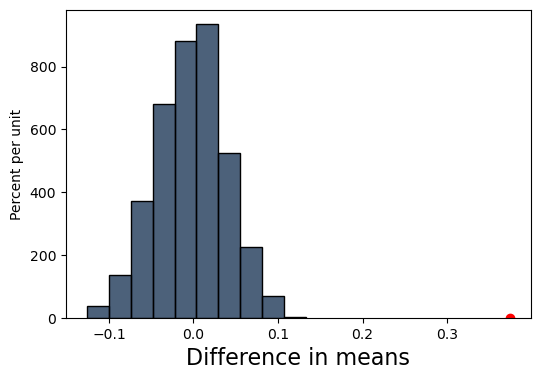

In [92]:
mean_diffs = make_array()
for i in np.arange(1000):
    shuffled_labels = relevant_households.sample(with_replacement = False).column("treatment_arm")
    shuffled_tbl = relevant_households.with_column("shuffled treatment", shuffled_labels)
    grouped_tbl = shuffled_tbl.group("shuffled treatment", np.mean)
    mean_diff = grouped_tbl.column("c12n21pnk mean").item(1) - grouped_tbl.column("c12n21pnk mean").item(0)
    mean_diffs = np.append(mean_diffs, mean_diff)
Table().with_columns("Difference in means", mean_diffs).hist()
plt.scatter(obs_diff, 0, c = 'red')

### Computing Confidence Intervals

Another way to compare between two groups is to examine and compare confidence intervals of each group's mean.
Let's compute a confidence interval for the percent of households using Chlorine (the measures validated by a Chlorine measurement) via resampling.


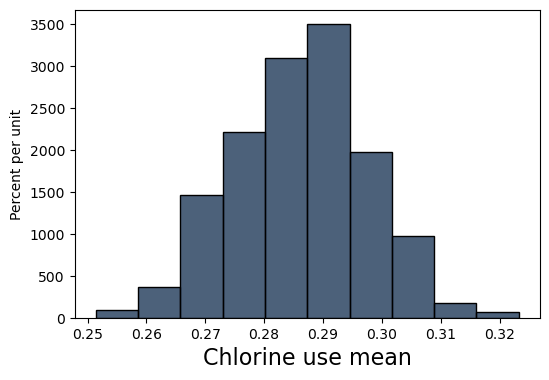

In [93]:
chlorine_uses = make_array()
for i in np.arange(1000):
    bootstrapped_sample = WGPRd2.sample()
    sample_mean = np.mean(bootstrapped_sample.column('c12n21pnk'))
    chlorine_uses = np.append(chlorine_uses, sample_mean)
Table().with_columns("Chlorine use mean", chlorine_uses).hist()

In [94]:
lower = percentile(2.5, chlorine_uses)
upper = percentile(97.5, chlorine_uses)
print(f"The 95% confidence interval is [{lower}, {upper}]")

The 95% confidence interval is [0.2646502835538752, 0.30812854442344045]


Using this technique we can look at the Confidence Intervals for each of the treatment arms.

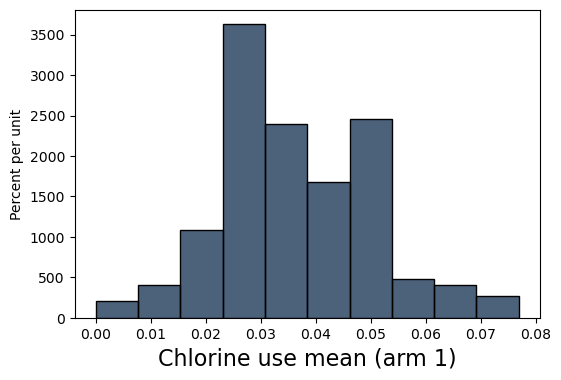

In [95]:
# Arm 1
arm_1 = WGPRd2.where("treatment_arm", 1)
chlorine_uses_arm1 = make_array()
for i in np.arange(1000):
    bootstrapped_sample = arm_1.sample()
    sample_mean = np.mean(bootstrapped_sample.column('c12n21pnk'))
    chlorine_uses_arm1 = np.append(chlorine_uses_arm1, sample_mean)
Table().with_columns("Chlorine use mean (arm 1)", chlorine_uses_arm1).hist()

In [96]:
lower = percentile(2.5, chlorine_uses_arm1)
upper = percentile(97.5, chlorine_uses_arm1)
print(f"The 95% confidence interval for arm 1 is [{lower}, {upper}]")

The 95% confidence interval for arm 1 is [0.011834319526627219, 0.0650887573964497]


Repeating for Arm 2...


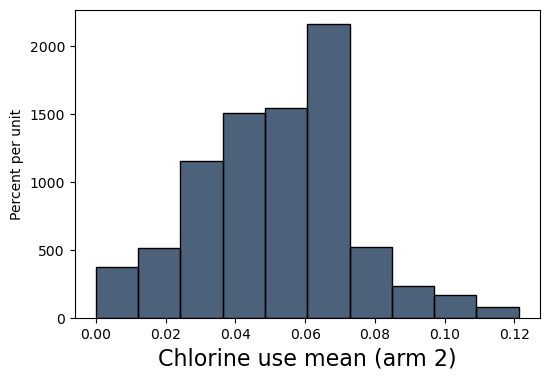

In [97]:
arm_2 = WGPRd2.where("treatment_arm", 2)
chlorine_uses_arm2 = make_array()
for i in np.arange(1000):
    bootstrapped_sample = arm_2.sample()
    sample_mean = np.mean(bootstrapped_sample.column('c12n21pnk'))
    chlorine_uses_arm2 = np.append(chlorine_uses_arm2, sample_mean)
Table().with_columns("Chlorine use mean (arm 2)", chlorine_uses_arm2).hist()

In [98]:
lower = percentile(2.5, chlorine_uses_arm2)
upper = percentile(97.5, chlorine_uses_arm2)
print(f"The 95% confidence interval for arm 2 is [{lower}, {upper}]")

The 95% confidence interval for arm 2 is [0.010101010101010102, 0.10101010101010101]


<!-- BEGIN QUESTION -->

**Question 4.1:** What can we tell by comparing the confidence intervals for Arm 1 and Arm 2? Do they overlap?  What does that mean?


_The confidence intervals for Arm 1 and Arm 2 are very similar, with most of the intervals overlapping each other. This likely means there was not much difference in the chlorine usage between the two arms, which is not especially surprising given what we talked about in lecture. I would expect to see arms 5-7 with more varied confidence intervals than the first two arms._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 4.2:** In the code cell below, test the data against another treatment arm. Construct the confidence interval via resampling and see if it is different than the control arm. Discuss your results in the markdown cell below.

_As I predicted in question 4.1, the confidence interval for arm 7 is much different than the intervals for arm 1 and arm 2. In fact, the confidence interval for arm 7 starts at 32.8%, whereas the max of the intervals for arms 1 and 2 were at 6.5% and 9%, respectively. This signals there was much higher chlorine usage in arm 7 then there was in arms 1 and 2._

The 95% confidence interval is [0.3253333333333333, 0.4266666666666667]


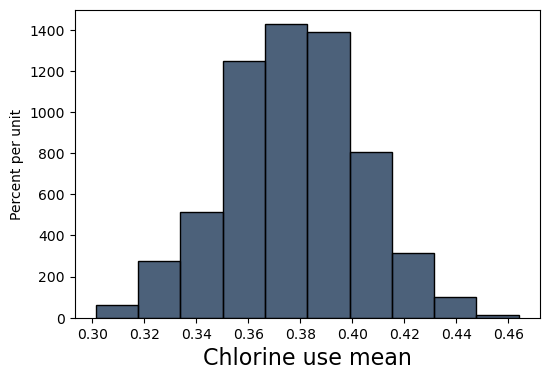

In [99]:
arm = WGPRd2.where("treatment_arm", 7)
chlorine_uses_arm = make_array()
for i in np.arange(1000):
    bootstrapped_sample = arm.sample()
    sample_mean = np.mean(bootstrapped_sample.column('c12n21pnk'))
    chlorine_uses_arm = np.append(chlorine_uses_arm, sample_mean)
Table().with_columns("Chlorine use mean", chlorine_uses_arm).hist()

lower = percentile(2.5, chlorine_uses_arm)
upper = percentile(97.5, chlorine_uses_arm)
print(f"The 95% confidence interval is [{lower}, {upper}]")

<!-- END QUESTION -->

<div id="Graph"></div>

## Graph of outcomes by Treatment Arm




### WGP Followup Round 2, Round 3, and across rounds

Now we will work on making a summary graph for the WGP study. This graph should show the seven treatment arms with the levels of our outcomes, and include error bars (the standard deviations of our sample means). In addition, we can work on customizing and saving our graph.  

In [100]:
WGPRd2 = WGP3rds_table.where("round", 2).select("a1_cmpd_id",'treatment_arm','Selfrptpct', 'Vldclpct')
WGPRd2

a1_cmpd_id,treatment_arm,Selfrptpct,Vldclpct
515520,1,0,0
511903,1,0,0
501212,1,0,0
518908,1,0,0
511914,1,0,0
507017,1,0,0
508517,1,0,0
500436,1,100,100
501216,1,0,0
516119,1,0,0


In [101]:
# Group by treatment_arm and take the means of each group
round2_means = WGPRd2.group('treatment_arm', np.mean)
round2_means

treatment_arm,a1_cmpd_id mean,Selfrptpct mean,Vldclpct mean
1,508712,5.91716,3.5503
2,509444,13.1313,5.05051
3,469899,18,10.6667
4,470342,16.0377,12.2642
5,490193,58.7349,40.9639
6,443467,57.8652,38.2022
7,508978,67.4667,37.8667


In [102]:
# Save the means into an array for later use
round2_means_self_array = round2_means.column('Selfrptpct mean')
round2_means_vld_array = round2_means.column('Vldclpct mean')

Let's start with a bar chart of the self reported Water Guard usage across treatment arms.

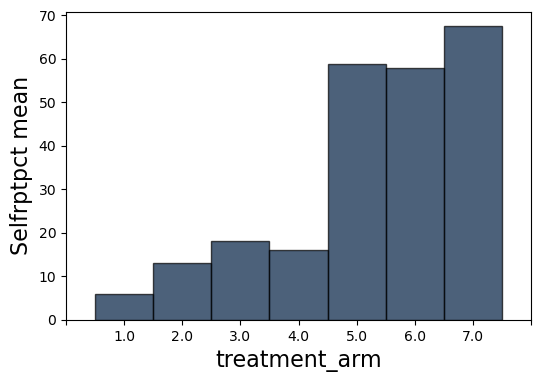

In [103]:
round2_means.bar('treatment_arm','Selfrptpct mean') 

Comparing the self reported values against the validated values:

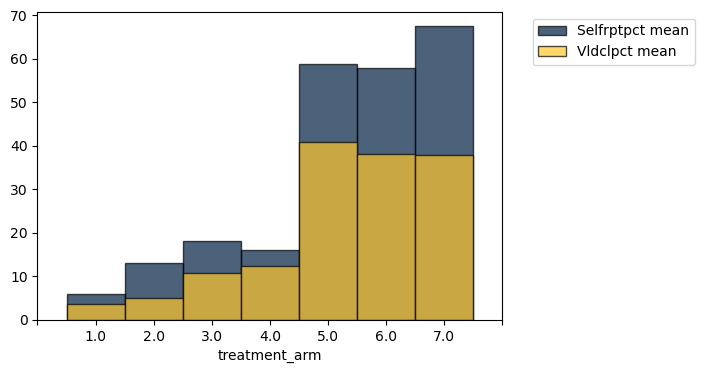

In [104]:
round2_means.bar('treatment_arm',make_array(2, 3)) 

Next, let's redo the same procedure for round 3.

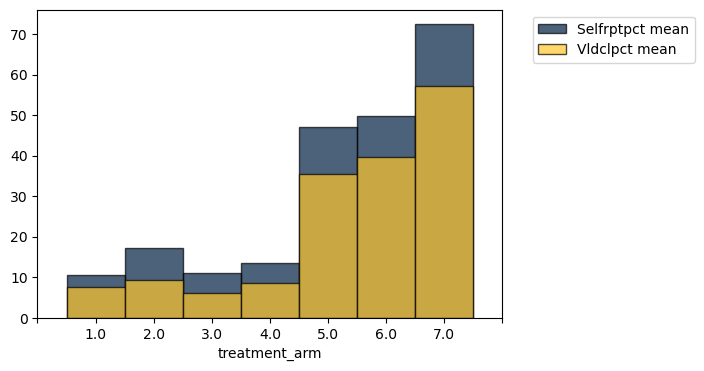

In [105]:
WGPRd3 = WGP3rds_table.where("round",3).select("a1_cmpd_id",'treatment_arm','Selfrptpct', 'Vldclpct')
round3_means = WGPRd3.group('treatment_arm', np.mean)
round3_means_array = round3_means.column('Selfrptpct mean')
round3_means.bar('treatment_arm' ,make_array(2, 3)) 

## Extra Credit - Practice with `matplotlib` and `pyplot`
Now let's try to make a graph that compares round 2 and round 3. 
This is a more complicated procedure, and requires us to use the `matplotlib` plotting library. 
Our `datascience` package uses `matplotlib` under the hood, but it is much more challenging to use.

Here are some references that you may find useful:
- https://matplotlib.org/gallery/api/barchart.html
- https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html

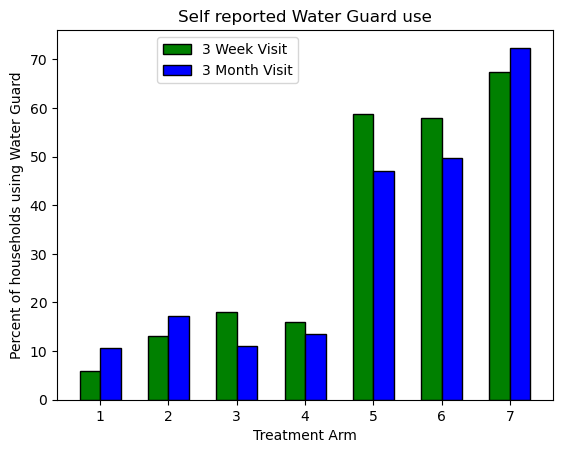

In [106]:
N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, round2_means_self_array, width, color='g')
rects2 = ax.bar(ind + width, round3_means_array, width, color='b')

# add some text for labels, title and axes ticks
ax.set_ylabel('Percent of households using Water Guard')
ax.set_title('Self reported Water Guard use')
ax.set_xlabel('Treatment Arm')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('1', '2', '3', '4', '5', '6','7'))
ax.legend((rects1[0], rects2[0])
          ,('3 Week Visit', '3 Month Visit')  # relabeling Round 2 and Round 3
          ,bbox_to_anchor=(0.5, 1.0))  # placing the legend in the graph 
plt.show()

# Uncomment the following line if you want to save the figure into an image file
# plt.savefig("self_reported_WG_use.png")

<!-- BEGIN QUESTION -->

**Question 5:** Make a version of this graph for Validated Presence of WG

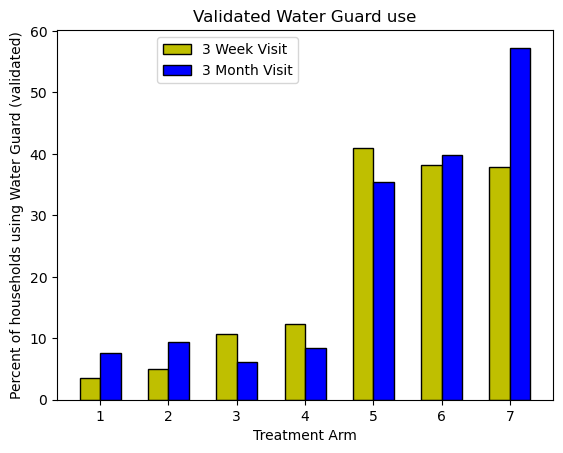

In [107]:
round2_means_vld_array = round2_means.column('Vldclpct mean')
round3_means_vld_array = round3_means.column('Vldclpct mean')

N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, round2_means_vld_array, width, color='y')
rects2 = ax.bar(ind + width, round3_means_vld_array, width, color='b')

# add some text for labels, title and axes ticks
ax.set_ylabel('Percent of households using Water Guard (validated)')
ax.set_title('Validated Water Guard use') 
ax.set_xlabel('Treatment Arm')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('1', '2', '3', '4', '5', '6','7'))
ax.legend((rects1[0], rects2[0])
          ,('3 Week Visit', '3 Month Visit')  # relabeling Round 2 and Round 3
          ,bbox_to_anchor=(0.5, 1.0))  # placing the legend in the graph 
plt.show()

# Uncomment the following line if you want to save the figure into an image file
# plt.savefig("validated_WG_use.png")

<!-- END QUESTION -->

Congrats! You've finished Lab 7!

---

## Submission
To submit this assignment, **save the notebook first** and run the cell below, then download the linked PDF and upload it to Gradescope.

In [108]:
from otter.export import export_notebook
from IPython.display import display, HTML

export_notebook("lab09.ipynb", filtering=True, pagebreaks=True)
display(HTML("Download your PDF <a href='lab09.pdf' download>here</a>."))